In [1]:
import joblib 

# Data Wrangling
import pandas as pd
import numpy as np

# Visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.regressor import residuals_plot, prediction_error

# Pipelines para tratar dados futuros
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# Seleção e validação de modelos
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

# Pré-processamento para incluir pipeline 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Modelos
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# Manter saída do processamento do sklearn como DataFrame pandas
from sklearn import set_config
set_config(transform_output = 'pandas')

In [2]:
def get_metrics(y_true, y_pred):
    dict_metrics = {
        'R2': metrics.r2_score(y_true, y_pred),
        'MAE': metrics.mean_absolute_error(y_true, y_pred),
        'MAPE': metrics.mean_absolute_percentage_error(y_true, y_pred),
        'RMSE': np.sqrt(metrics.mean_squared_error(y_true, y_pred)),
    }

    return dict_metrics

In [3]:
df = pd.read_csv('../data/insurance.csv')
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [4]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


<Axes: xlabel='age', ylabel='charges'>

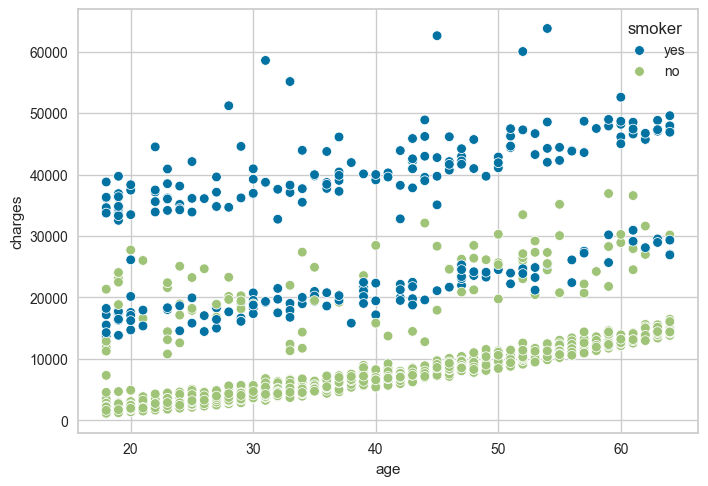

In [6]:
sns.scatterplot(data = df, x = 'age', y = 'charges', hue = 'smoker')

<Axes: xlabel='bmi', ylabel='charges'>

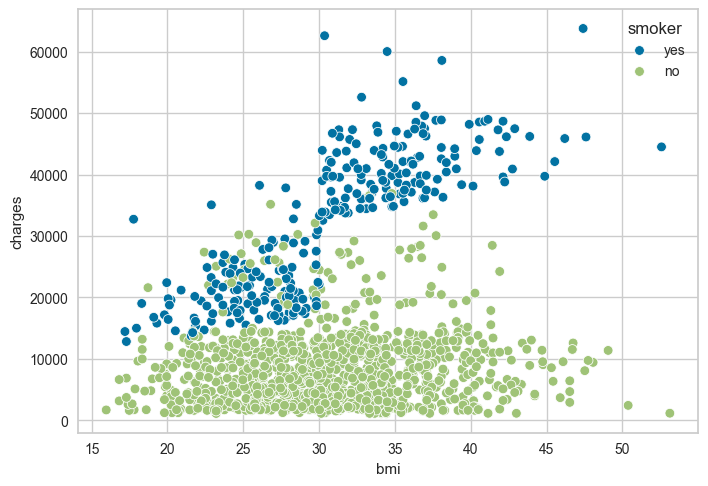

In [7]:
sns.scatterplot(data = df, x = 'bmi', y = 'charges', hue = 'smoker')

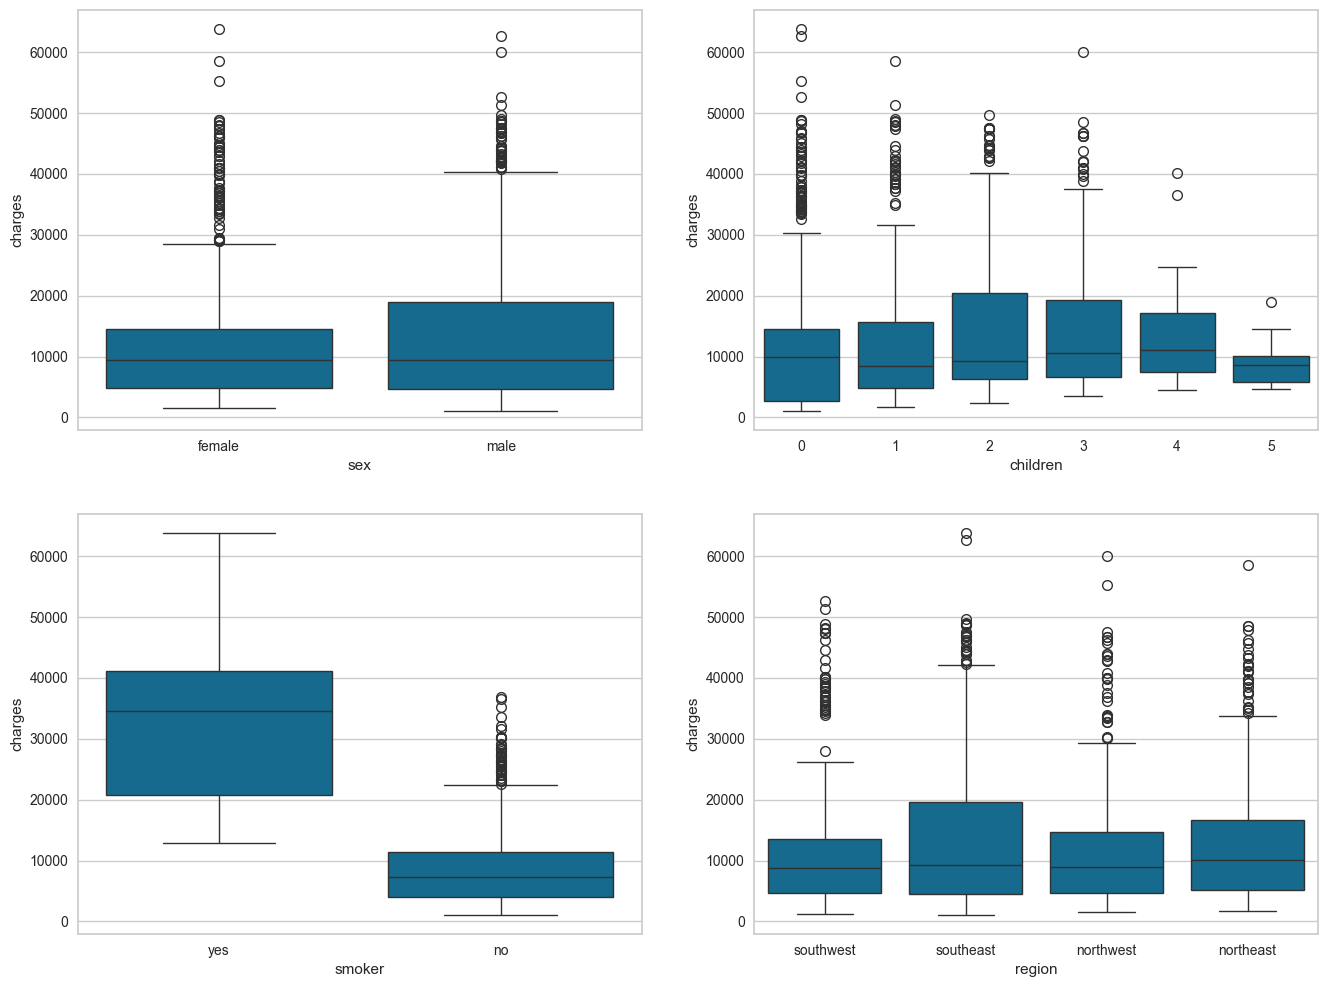

In [8]:
cat_plot_cols = ['sex', 'children', 'smoker', 'region']

f, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (16, 12))
for col, ax in zip(cat_plot_cols, axes.flatten()):
    sns.boxplot(x = col, y = 'charges', data = df, ax = ax)

<Axes: >

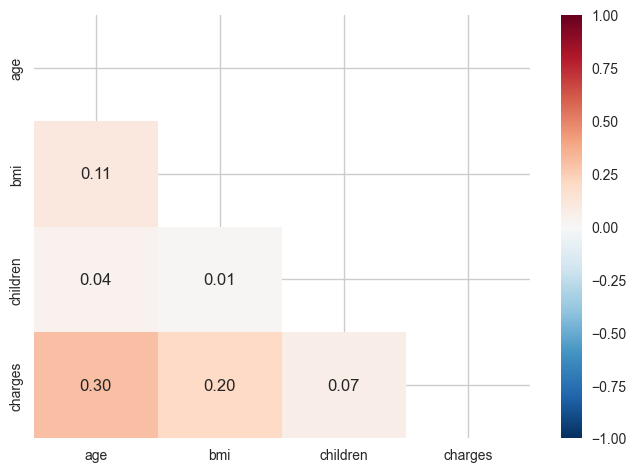

In [9]:
dfc = df[['age', 'bmi', 'children', 'charges']].corr()
mask = np.zeros(dfc.shape).astype(bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(dfc, annot = True, center = 0, vmax = 1, vmin = -1, cmap = 'RdBu_r', fmt = '.2f', mask = mask)

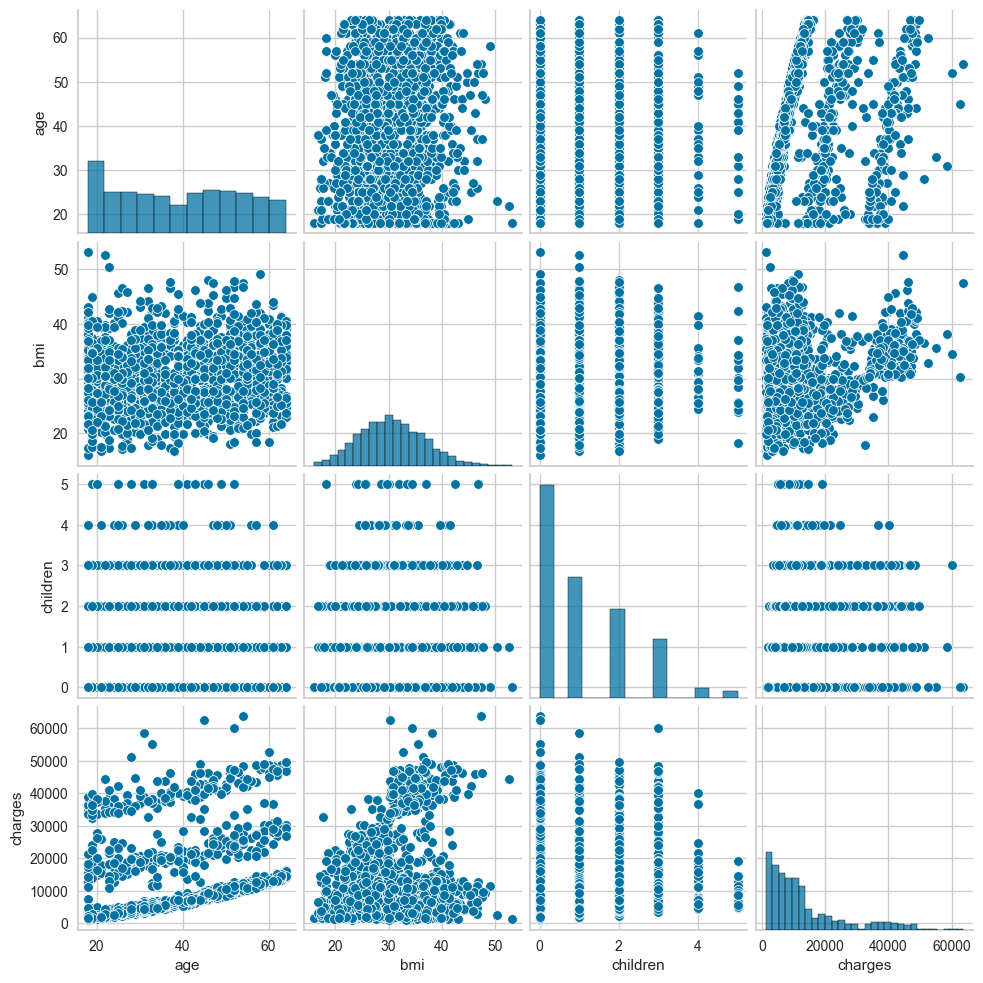

In [10]:
sns.pairplot(df)

# Modeling

In [11]:
numerical_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'smoker', 'region']

features = numerical_features + categorical_features
target = 'charges'

In [12]:
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2023)

In [13]:
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = OneHotEncoder(drop = 'if_binary', handle_unknown = 'ignore', sparse_output = False)

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

preprocessor.fit_transform(X_train)

,num__age,num__bmi,num__children,cat__sex_male,cat__smoker_yes,cat__region_northeast,cat__region_northwest,cat__region_southeast,cat__region_southwest
1068,0.978261,0.153349,0.2,1.0,0.0,0.0,1.0,0.0,0.0
1018,0.782609,0.534167,0.6,0.0,0.0,0.0,1.0,0.0,0.0
995,0.456522,0.196798,0.6,0.0,0.0,1.0,0.0,0.0,0.0
1248,0.000000,0.641916,0.0,0.0,0.0,0.0,0.0,1.0,0.0
549,0.543478,0.813559,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
884,0.152174,0.288808,0.8,1.0,0.0,0.0,1.0,0.0,0.0
515,0.869565,0.531073,0.0,1.0,0.0,0.0,0.0,0.0,1.0
695,0.173913,0.651735,0.0,0.0,0.0,0.0,1.0,0.0,0.0
454,0.304348,0.822437,0.4,1.0,0.0,0.0,0.0,1.0,0.0


In [14]:
model_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('model', DummyRegressor())
])

In [15]:
params = {
    'model': [
        DummyRegressor(),
        LinearRegression(),
        LassoCV(),
        RidgeCV(),
        RandomForestRegressor(random_state = 2023),
        GradientBoostingRegressor(random_state = 2023)
    ]
}

grid_model = GridSearchCV(model_pipeline, params, cv = 5, scoring = 'r2', n_jobs = -1, verbose = 1)
grid_model.fit(X_train, y_train);

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [16]:
grid_model.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('model', GradientBoostingRegressor(random_state=2023))])

In [17]:
df_cv_results = pd.DataFrame(grid_model.cv_results_).set_index('rank_test_score').sort_index()
df_cv_results.loc[:, ~df_cv_results.columns.str.contains('split | time')] 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,
1,0.310058,0.037572,0.023976,0.005856,GradientBoostingRegressor(random_state=2023),{'model': GradientBoostingRegressor(random_sta...,0.857091,0.854775,0.843129,0.840171,0.853438,0.849721,0.006758
2,0.742322,0.014376,0.036865,0.006302,RandomForestRegressor(random_state=2023),{'model': RandomForestRegressor(random_state=2...,0.844109,0.848074,0.831330,0.836266,0.844246,0.840805,0.006099
3,0.210087,0.007209,0.024363,0.003465,LassoCV(),{'model': LassoCV()},0.758285,0.714893,0.737520,0.752047,0.756104,0.743770,0.016151
4,0.039073,0.002055,0.031817,0.004250,RidgeCV(),{'model': RidgeCV()},0.758278,0.714799,0.737557,0.752069,0.756020,0.743745,0.016170
5,0.048625,0.009973,0.025225,0.001805,LinearRegression(),{'model': LinearRegression()},0.758278,0.714762,0.737599,0.752049,0.755995,0.743737,0.016174
6,0.040986,0.003560,0.030560,0.008123,DummyRegressor(),{'model': DummyRegressor()},-0.002956,-0.000186,-0.000243,-0.000861,-0.000981,-0.001045,0.001007


In [18]:
model_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state = 2023)),
])

params = {
    'model__learning_rate': [0.1, 0.01],
    'model__max_depth': [3, 4, 5],
    'model__n_estimators': [300, 400, 500],
    'model__subsample': [1.0, 0.8],
}

grid_model = GridSearchCV(model_pipeline, params, cv = 5, scoring = 'r2', n_jobs = -1, verbose = 1)
grid_model.fit(X_train, y_train);

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [19]:
df_cv_results = pd.DataFrame(grid_model.cv_results_).set_index('rank_test_score').sort_index()
df_cv_results.loc[:, ~df_cv_results.columns.str.contains('split | time')].head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,,
1,1.638826,0.354297,0.043041,0.015403,0.01,3,400,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.861072,0.861570,0.848556,0.853727,0.865717,0.858128,0.006150
2,2.265491,0.614837,0.058938,0.018848,0.01,3,500,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.861041,0.862363,0.848625,0.851857,0.865180,0.857813,0.006408
3,1.620466,0.186964,0.030134,0.003125,0.01,3,400,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.860566,0.859824,0.846292,0.853409,0.865086,0.857035,0.006536
4,2.192829,0.637531,0.051659,0.039712,0.01,3,500,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.861419,0.859301,0.846486,0.851914,0.864086,0.856641,0.006493
5,1.224789,0.332911,0.051911,0.024768,0.01,3,300,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.858014,0.857782,0.847360,0.855172,0.863647,0.856395,0.005296


In [20]:
model_pipeline = grid_model.best_estimator_

In [21]:
y_pred = model_pipeline.predict(X_test)
get_metrics(y_test, y_pred)

{'R2': 0.8666376387968089,
 'MAE': 2497.122249202784,
 'MAPE': 0.3013239427631112,
 'RMSE': np.float64(4190.521276202634)}

<Axes: xlabel='charges'>

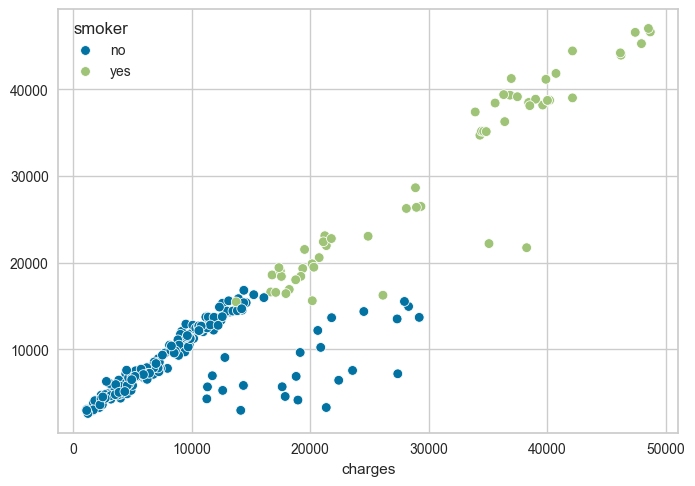

In [22]:
sns.scatterplot(x = y_test, y = y_pred, hue = X_test.smoker)

<Axes: >

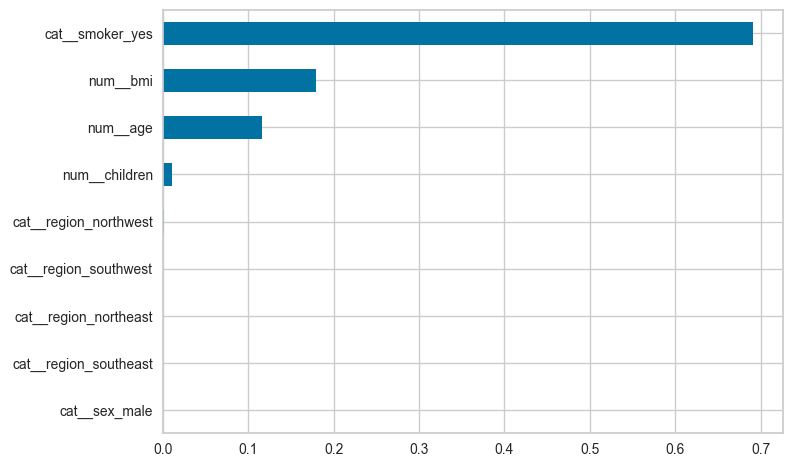

In [23]:
importances = pd.Series(
    data = model_pipeline.named_steps['model'].feature_importances_,
    index = model_pipeline.named_steps['preprocessor'].get_feature_names_out()
)

importances.sort_values().plot.barh()

In [24]:
numerical_features = ['age', 'bmi', 'children']
categorical_features = ['smoker']

features = numerical_features + categorical_features
target = 'charges'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2023)

In [25]:
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = OneHotEncoder(drop = 'if_binary', handle_unknown = 'ignore', sparse_output = False)

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

model_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state = 2023)),
])

params = {
    'model__learning_rate': [0.1, 0.01],
    'model__max_depth': [3, 4, 5],
    'model__n_estimators': [300, 400, 500],
    'model__subsample': [1.0, 0.8],
}

grid_model = GridSearchCV(model_pipeline, params, cv = 5, scoring = 'r2', n_jobs = -1, verbose = 1)
grid_model.fit(X_train, y_train);

df_cv_results = pd.DataFrame(grid_model.cv_results_).set_index('rank_test_score').sort_index()
df_cv_results.loc[:, ~df_cv_results.columns.str.contains('split | time')].head()


Fitting 5 folds for each of 36 candidates, totalling 180 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,,
1,1.134779,0.078830,0.042121,0.020650,0.01,3,400,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.861768,0.860509,0.848767,0.855080,0.865357,0.858296,0.005796
2,1.484318,0.122571,0.036922,0.014424,0.01,3,500,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.861557,0.860134,0.848361,0.853500,0.864530,0.857616,0.005870
3,1.524855,0.143896,0.026137,0.004542,0.01,3,500,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.861031,0.861180,0.846959,0.852856,0.865062,0.857418,0.006570
4,1.248597,0.059448,0.028710,0.007416,0.01,3,400,1.0,"{'model__learning_rate': 0.01, 'model__max_dep...",0.861384,0.858977,0.846558,0.854628,0.865226,0.857355,0.006400
5,0.903584,0.040963,0.039543,0.015139,0.01,3,300,0.8,"{'model__learning_rate': 0.01, 'model__max_dep...",0.858611,0.857398,0.847896,0.856109,0.863659,0.856735,0.005107


In [26]:
model_pipeline = grid_model.best_estimator_
y_pred = model_pipeline.predict(X_test)

get_metrics(y_test, y_pred)

{'R2': 0.8658322662820985,
 'MAE': 2488.7894076326684,
 'MAPE': 0.29804532488286706,
 'RMSE': np.float64(4203.155465756373)}

<Axes: >

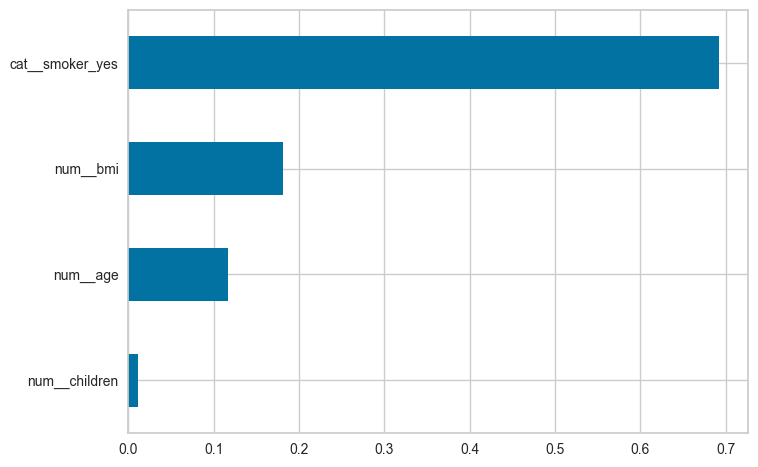

In [27]:
importances = pd.Series(
    data = model_pipeline.named_steps['model'].feature_importances_,
    index = model_pipeline.named_steps['preprocessor'].get_feature_names_out()
)

importances.sort_values().plot.barh()

In [29]:
joblib.dump(model_pipeline, '../models/model.pkl')

['../models/model.pkl']